# Base year (2023) validation

This notebook validates the results of PyPSA-Earth for the base year (2023) against the **EIA (U.S. Energy Information Administration)** and **Ember** US datasets. The validation covers three key aspects of the electricity system:
- **Electricity Demand**
- **Electricity Generation**
- **Installed Generation Capacity**

## 1. Setup and Data Loading

*This section handles the initial setup, including importing necessary libraries and loading the solved PyPSA-Earth networks.*

### 11.1 Loading libraries

We begin by importing the necessary libraries for data handling, analysis, and visualization. These include PyPSA for power system analysis, pandas and numpy for data manipulation, geopandas for spatial data, and seaborn/matplotlib for plotting.

---

In [1]:
# Install required packages if not already installed
# Uncomment the line below to install packages
# Note: This line is commented out to prevent installation during code execution.

# !pip install numpy pandas plotly pycountry matplotlib seaborn -qq

In [2]:
import os
import pypsa
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import pycountry

from _helpers import *

import warnings
warnings.filterwarnings("ignore")

/home/user/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.width', None)    
pd.set_option('display.max_colwidth', None)

### 1.3 Loading Files

PyPSA-Earth solved networks for the base year are uploaded here, as well as the relevant EIA and Ember datasets. These datasets provide reference values for demand, generation, and installed capacity, which will be used for validation.

In [4]:
DATA_DIR = "../notebooks/validation_data/"

ember_data_path = os.path.join(DATA_DIR, "ember_yearly_full_release_long_format.csv")
eia_demand_path = os.path.join(DATA_DIR, "EIA_demand.xlsx")
eia_installed_capacities_path = os.path.join(DATA_DIR, "EIA_installed_capacities.csv")
eia_generation_path = os.path.join(DATA_DIR, "EIA_electricity_generation.csv")

In [5]:
ember_data = pd.read_csv(ember_data_path)

In [6]:
# load network
project_root = os.getcwd()
results_dir = os.path.join(project_root, 'results')

# Load Base year network
base_path = os.path.join(results_dir, 'base_year', "elec_s_100_ec_lcopt_Co2L-24H_24H_2020_0.071_AB_10export.nc")
base_network = pypsa.Network(base_path)

INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_Co2L-24H_24H_2020_0.071_AB_10export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [7]:
state_shape_path = "gadm41_USA_1.json"
grid_shape_path = "needs_grid_regions_aggregated.geojson"
attach_state_to_buses(base_network, state_shape_path)
attach_grid_region_to_buses(base_network, grid_shape_path)

In [8]:
country_code = "US"
horizon = 2023

three_country_code = convert_two_country_code_to_three(country_code)

---

## 2. Installed capacity 

This section validates the **installed generation capacities** by technology. We compare the capacities in the PyPSA network to those reported by EIA and Ember to ensure the model's infrastructure assumptions are consistent with real-world data.

In [9]:
installed_capacity_ember = get_installed_capacity_ember(
        ember_data, three_country_code, horizon).round(2)

EIA_inst_capacities = get_data_EIA(
    eia_installed_capacities_path, country_code, horizon)
EIA_inst_capacities = preprocess_eia_data(EIA_inst_capacities).round(2)

installed_capacity_ember.rename({
    "Gas": "Natural gas", "Fossil fuels": "Oil"
}, inplace=True)

In [10]:
gen_carriers = {
    "onwind", "offwind-ac", "offwind-dc", "solar", "solar rooftop",
    "csp", "nuclear", "geothermal", "ror", "PHS", "hydro"
}
link_carriers = {
    "OCGT", "CCGT", "coal", "oil", "biomass", "biomass CHP", "gas CHP"
}

# Generators
gen = base_network.generators.copy()
gen['carrier'] = gen['carrier'].replace({'offwind-ac': 'offwind', 'offwind-dc': 'offwind'})
gen = gen[gen.carrier.isin(gen_carriers)]
gen_totals = gen.groupby('carrier')['p_nom_opt'].sum()

# Storage
sto = base_network.storage_units.copy()
sto = sto[sto.carrier.isin(gen_carriers)]
sto_totals = sto.groupby('carrier')['p_nom_opt'].sum()

# Links (output side scaled by efficiency)
links = base_network.links.copy()
mask = (
    links.efficiency.notnull()
    & (links.p_nom_opt > 0)
    & links.carrier.isin(link_carriers)
)
links = links[mask]
links_totals = links.groupby('carrier').apply(
    lambda df: (df['p_nom_opt'] * df['efficiency']).sum()
)

# Combine all
all_totals = pd.concat([gen_totals, sto_totals, links_totals])
all_totals = all_totals.groupby(all_totals.index).sum()  # Merge duplicates
all_totals = all_totals[all_totals > 0] / 1e3

In [11]:
pypsa_cap = (
    all_totals.rename({
        "onwind": "Wind", "offwind": "Wind", "solar rooftop": "Solar",
        "solar": "Solar", "ror": "Hydro", "geothermal": "Geothermal", "nuclear": "Nuclear", "hydro": "Hydro",
        "OCGT": "Natural gas", "CCGT": "Natural gas", "oil": "Oil",
        "coal": "Coal", "biomass": "Biomass",
    })
    .to_frame('PyPSA-Earth results')
    .round(2)
    .groupby(level=0).sum()
)

# skip 0
pypsa_cap = pypsa_cap[pypsa_cap['PyPSA-Earth results'] > 0]

In [12]:
fossil_fuels = ["Natural gas", "Oil", "Coal"]

# Sum fossil fuels, no KeyError if a carrier is missing
pypsa_fossil_fuels = pypsa_cap.reindex(fossil_fuels, fill_value=0).sum().iloc[0]
ember_fossil_fuels = installed_capacity_ember.reindex(fossil_fuels, fill_value=0).sum().iloc[0]

# Add the aggregated "Fossil fuels" row
pypsa_cap.loc['Fossil fuels'] = pypsa_fossil_fuels
installed_capacity_ember.loc['Fossil fuels'] = ember_fossil_fuels

# Concatenate all dataframes
installed_capacity_df = pd.concat(
    [pypsa_cap, installed_capacity_ember, EIA_inst_capacities], axis=1
).fillna(0)

# Replace 0 with "N/A" for readability
installed_capacity_df_na = installed_capacity_df.replace(0, "N/A")

installed_capacity_df_na


,PyPSA-Earth results,Ember data,EIA data
Biomass,9.02,9.96,29.28
Coal,226.98,200.28,N/A
Geothermal,4.02,N/A,2.7
Hydro,79.98,86.66,79.99
Natural gas,563.70,542.93,N/A
Nuclear,99.96,95.77,95.75
Oil,32.58,32.16,N/A
PHS,22.02,N/A,23.15
Solar,142.25,139.21,139.77
Wind,149.16,148.02,147.44


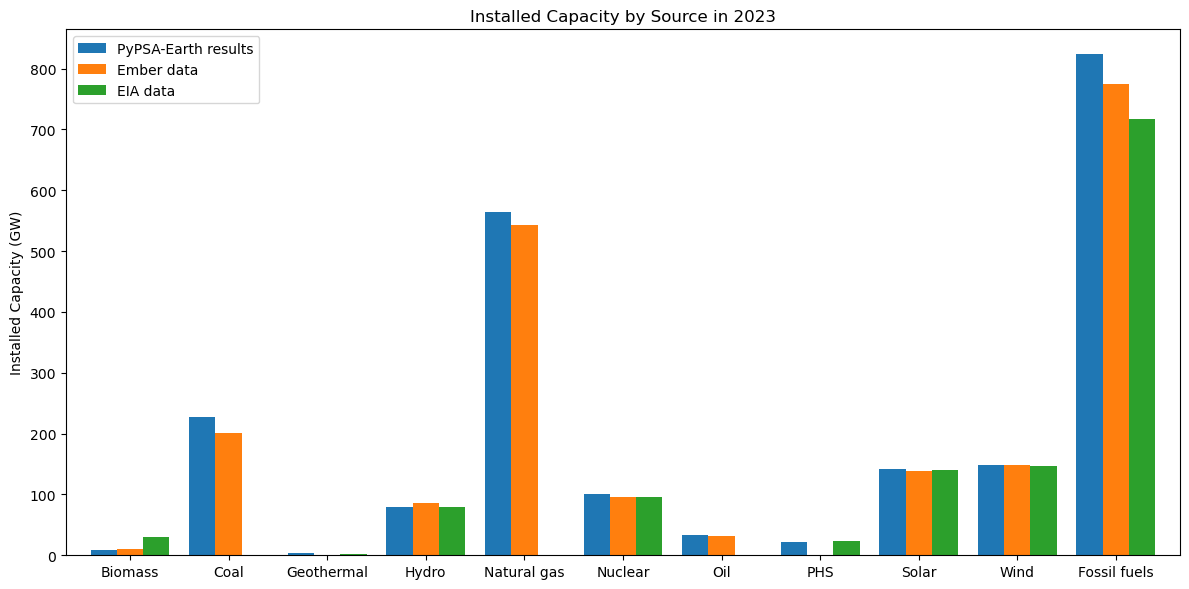

In [13]:
installed_capacity_df.plot(kind="bar", figsize=(12, 6), width=0.8)
plt.title(f"Installed Capacity by Source in {horizon}")
plt.ylabel("Installed Capacity (GW)")
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.tight_layout()

Installed capacity data source <br>
Ember source: https://ember-energy.org/data/electricity-data-explorer/?data=capacity&entity=United+States <br>
EIA source: https://www.eia.gov/international/data/world/electricity/electricity-capacity

---

## 3. Electricity generation

In this section, we compare the **annual electricity generation** by technology as reported by PyPSA-Earth, EIA, and Ember. This helps to identify any discrepancies in the modeled generation mix and total output.

In [14]:
# ember_data = load_ember_data()
generation_data_ember = get_generation_capacity_ember_detail(
        ember_data, three_country_code, horizon).round(2)
generation_data_ember.drop(['Load shedding', 'Other Fossil'], inplace=True)

eia_generation = get_data_EIA(eia_generation_path, country_code, horizon)
eia_generation = preprocess_eia_data_detail(eia_generation).round(2)

In [15]:
pypsa_gen_final = calculate_total_generation_by_carrier(base_network).rename({
        "CCGT": "Natural gas",  "OCGT": "Natural gas", "Csp": "Solar",
        "biomass EOP": "Biomass", "biomass": "Biomass", "coal": "Coal",
        "oil": "Oil", "urban central gas CHP": "Natural gas", "ror": "Hydro",
        "urban central solid biomass CHP": "Biomass", "nuclear": "Nuclear",
        "solar": "Solar", "solar rooftop": "Solar", "hydro": "Hydro", "Reservoir & Dam": "Hydro",
        "onwind": "Wind", "offwind": "Wind", "geothermal": "Geothermal",
    }).to_frame('PyPSA-Earth results').groupby(level=0).sum().round(2)

In [16]:
generation_df = pd.concat(
    [pypsa_gen_final, generation_data_ember, eia_generation], axis=1).fillna(0)

totals_row = generation_df.sum().to_frame().T
totals_row.index = ['Total']
generation_df_with_totals = pd.concat([generation_df, totals_row])

display(generation_df_with_totals)

,PyPSA-Earth results,Ember data,EIA data
Biomass,79.00,47.46,57.16
Coal,528.15,675.26,675.12
Geothermal,35.25,0.00,16.37
Hydro,247.01,233.96,245.00
Natural gas,1933.41,1802.06,1806.06
Nuclear,779.33,775.35,774.87
Oil,0.11,0.00,16.23
Solar,201.68,238.12,238.94
Wind,388.47,425.23,421.14
PHS,0.00,0.00,-5.99


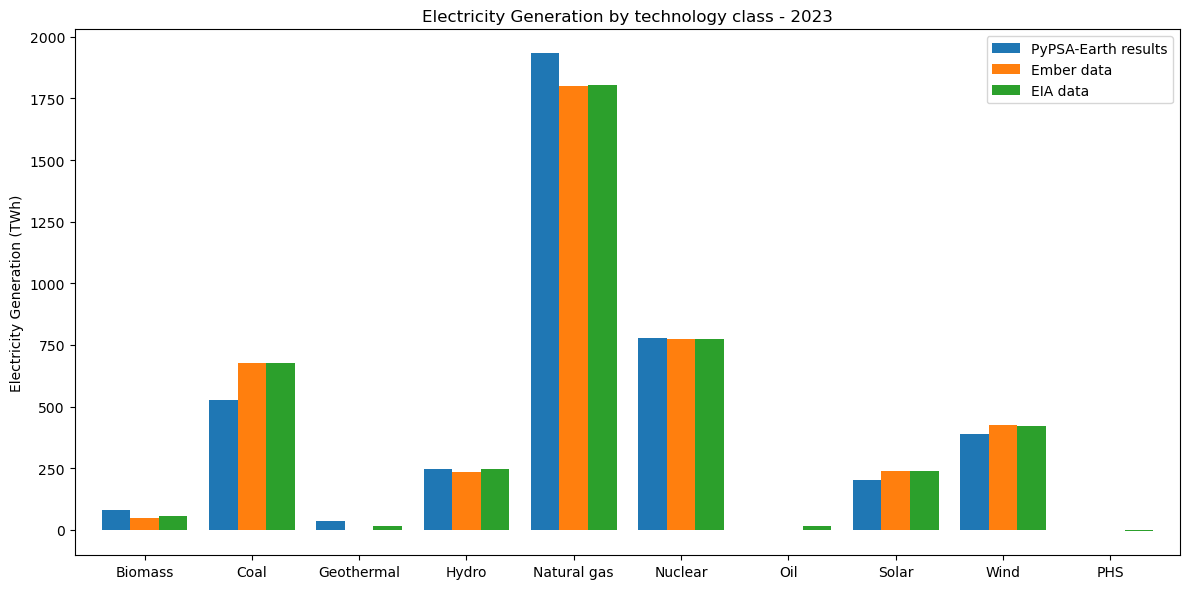

In [17]:
generation_df.plot(kind="bar", figsize=(12, 6), width=0.8)
plt.title(f"Electricity Generation by technology class - {horizon}")
plt.ylabel("Electricity Generation (TWh)")
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.tight_layout()

Electricity generation <br>
Ember source: https://ember-energy.org/data/us-electricity-data/ <br>
EIA source: https://www.eia.gov/international/data/world/electricity/electricity-generation

---

## 4. Electricity demand

Finally, we validate the **electricity demand** in the PyPSA network against the EIA and Ember datasets. This ensures that the modeled demand matches observed values for the base year.

### 4.1 Total electricity demand

*Total electricity demand in PyPSA-Earth (US) uses NREL as a reference (see the `scenario_analysis_single` notebook.*

### 4.2 State-wise Total Electricity Demand

*A bar plot showing the state-wise annual electricity demand for the base year (2023) to validate the quality of the spatial distribution of demand.*

In [18]:
demand_ember = get_demand_ember(ember_data, three_country_code, horizon)
_, pypsa_demand =compute_demand(base_network)

EIA_demand = preprocess_eia_demand(eia_demand_path, horizon)

In [19]:
base_demand_grid_region, base_demand_state = compute_demand(base_network)

In [20]:
demand_total =  pd.concat([EIA_demand, base_demand_state.sum(axis=1)], axis=1).rename({0: 'PyPSA-Earth'}, axis=1)

In [21]:
fig = px.bar(demand_total, barmode='group')
fig.update_layout(width=2500, 
                  height=700, 
                  yaxis_title='Demand (TWh)',
                  xaxis_title='States',
                  title=f'Electricity Demand for {horizon}')
fig.show()

Electricity demand <br>
EIA source: https://www.eia.gov/state/seds/seds-data-complete.php?sid=US#Consumption <br> 
https://www.eia.gov/state/seds/sep_use/total/csv/use_all_phy.xlsx

In [22]:
total_region_demand = base_demand_grid_region.sum(axis=1)
base_demand_grid_region["Total"] = total_region_demand
base_demand_grid_region.T

region,Alaska,California,Delta,Florida,Hawaii,Mid-Atlantic,Midwest,Mountain,New England,New York,Northwest,Plains,Southeast,Southwest,Texas
carrier,,,,,,,,,,,,,,,
AC,1.12,98.78,51.75,87.85,3.49,300.61,185.84,39.96,34.15,76.90,74.02,113.84,190.53,58.81,154.06
agriculture electricity,0.05,5.33,1.22,3.30,0.16,8.93,8.01,2.94,2.01,4.76,2.47,4.66,6.65,2.73,4.04
industry electricity,0.94,66.81,35.77,26.49,2.46,131.41,100.11,31.46,29.89,77.43,26.46,56.69,63.19,21.45,61.92
land transport EV,0.01,1.24,0.30,0.74,0.04,2.16,1.94,0.70,0.49,1.17,0.59,1.12,1.56,0.65,0.92
rail transport electricity,0.00,0.52,0.12,0.32,0.02,0.86,0.76,0.29,0.20,0.46,0.24,0.45,0.65,0.27,0.39
services electricity,1.02,89.87,47.09,79.92,3.18,273.49,169.05,36.36,31.07,69.96,67.34,103.55,173.36,53.51,140.17
Total,3.14,262.55,136.25,198.62,9.35,717.46,465.71,111.71,97.81,230.68,171.12,280.31,435.94,137.42,361.50


In [23]:
total_region_demand = base_demand_state.sum(axis=1)
base_demand_state["Total"] = total_region_demand
base_demand_state.T

region,AK,AL,AR,AZ,CA,CO,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NM,NV,NY,OH,OK,OR,PA,SC,SD,TN,TX,UT,VA,WA,WI,WV,WY
carrier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AC,1.12,29.27,15.92,30.28,102.53,18.53,93.52,56.29,3.49,24.56,16.10,48.65,31.06,25.32,28.06,33.37,30.12,35.40,4.03,34.42,22.97,27.93,8.17,4.90,19.30,10.55,8.70,0.00,19.60,14.30,76.90,48.33,23.15,24.17,60.94,36.12,2.57,43.88,179.76,11.30,94.84,29.61,25.24,11.57,4.87
agriculture electricity,0.05,0.66,0.50,0.96,6.86,0.80,4.23,1.22,0.16,0.87,1.03,1.74,1.21,1.79,1.03,0.70,1.72,1.37,0.29,1.29,0.92,1.04,0.24,0.18,0.64,0.23,0.14,0.00,1.17,0.92,4.76,1.71,0.51,0.35,2.82,1.69,0.21,1.51,5.21,0.35,1.41,1.00,1.29,0.41,0.07
industry electricity,0.94,9.27,6.08,6.55,82.22,8.33,34.15,9.92,2.46,10.64,8.28,27.12,13.99,21.48,12.00,29.17,26.07,20.79,3.75,16.97,13.24,11.95,2.95,2.74,5.26,3.51,1.62,0.07,10.59,7.53,77.43,22.14,8.66,3.46,46.23,14.10,2.54,16.98,74.63,3.26,15.60,13.89,14.57,8.03,1.32
land transport EV,0.01,0.15,0.12,0.23,1.60,0.19,0.95,0.29,0.04,0.21,0.25,0.42,0.29,0.46,0.25,0.17,0.42,0.33,0.07,0.31,0.23,0.24,0.06,0.04,0.15,0.06,0.03,0.00,0.27,0.22,1.17,0.41,0.12,0.08,0.68,0.40,0.05,0.36,1.19,0.09,0.34,0.24,0.32,0.10,0.02
rail transport electricity,0.00,0.07,0.05,0.10,0.67,0.08,0.41,0.12,0.02,0.08,0.10,0.16,0.12,0.17,0.10,0.07,0.17,0.13,0.03,0.12,0.08,0.10,0.02,0.02,0.06,0.02,0.01,0.00,0.11,0.09,0.46,0.17,0.05,0.03,0.27,0.16,0.02,0.15,0.51,0.03,0.14,0.10,0.13,0.04,0.01
services electricity,1.02,26.63,14.49,27.55,93.28,16.87,85.08,51.21,3.18,22.34,14.65,44.25,28.25,23.03,25.52,30.36,27.40,32.21,3.67,31.32,20.90,25.40,7.44,4.45,17.56,9.60,7.91,0.00,17.83,13.01,69.96,43.97,21.05,21.99,55.45,32.87,2.34,39.93,163.55,10.28,86.29,26.94,22.96,10.52,4.43
Total,3.14,66.05,37.16,65.67,287.16,44.80,218.34,119.05,9.35,58.70,40.41,122.34,74.92,72.25,66.96,93.84,85.90,90.23,11.84,84.43,58.34,66.66,18.88,12.33,42.97,23.97,18.41,0.07,49.57,36.07,230.68,116.73,53.54,50.08,166.39,85.34,7.73,102.81,424.85,25.31,198.62,71.78,64.51,30.67,10.72


In [24]:
fig1 = px.bar(base_demand_grid_region.drop(columns=["Total"], errors='ignore'), barmode='stack', text_auto='.1f')
fig1.update_layout(width=1100, yaxis_title='Demand (TWh)', xaxis_title='Grid regions', title='Electricity demand by type of load and Grid region (2023)')
fig1.show()

fig1 = px.bar(base_demand_state.drop(columns=["Total"]), barmode='stack', text_auto='.1f')
fig1.update_layout(width=3000, yaxis_title='Demand (TWh)', xaxis_title='States', title='Electricity Demand by type of load and State (2023)')
fig1.show()